In [32]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
import lightkurve as lk
import pandas as pd
from bisect import bisect_left

plt.rcParams.update({'font.size': 18})

na1 = 5889.6
na2 = 5895.7
mg = 5176.7
ca1 = 8500.36
ca2 = 8544.44
ca3 = 8664.52
ca2k = 3934.777
ca2h = 3969.588
ch = 4302
halpha = 6564.61
hbeta = 4862.68

In [2]:
def cont_norm(wl, fl, centre, window, edge):
    c1 = bisect_left(wl, centre - window)
    c2 = bisect_left(wl, centre + window)
    wl, fl = wl[c1:c2], fl[c1:c2]
    
    mask = np.ones(len(wl))
    mask[edge:-edge] = 0
    mask = mask.astype(bool)

    p = np.polynomial.polynomial.polyfit(wl[mask], fl[mask], 1)
    continuum = np.polynomial.polynomial.polyval(wl, p)
    norm_fl = fl / continuum
    return wl, norm_fl

In [3]:
## Load Models

import glob

Cfiles = np.sort(glob.glob('d62_models/*C*'))
Ofiles = np.sort(glob.glob('d62_models/*O*'))

Cdict = {};
Odict = {};

print(Ofiles)
print(Cfiles)

import csv

for filename in Cfiles:

    wl = [];
    fl = [];

    with open(filename, 'r') as fd:
        reader = csv.reader(fd)
        for ii,row in enumerate(reader):
            if ii == 0:
                pass
            if ii > 0 and 'Effective' not in row[0]:
                wl.extend(np.array(row[0].split()).astype(float))

            if 'Effective' in row[0]:
                break

        for jj,row in enumerate(reader):
            if jj <= ii:
                pass

            fl.extend(np.array(row[0].split()).astype(float))
        
        abundance = filename.split('_')[-1]
        Cdict[abundance] = np.array(fl)

for filename in Ofiles:

    wl = [];
    fl = [];

    with open(filename, 'r') as fd:
        reader = csv.reader(fd)
        for ii,row in enumerate(reader):
            if ii == 0:
                pass
            if ii > 0 and 'Effective' not in row[0]:
                wl.extend(np.array(row[0].split()).astype(float))

            if 'Effective' in row[0]:
                break

        for jj,row in enumerate(reader):
            if jj <= ii:
                pass

            fl.extend(np.array(row[0].split()).astype(float))
        
        abundance = filename.split('_')[-1]
        Odict[abundance] = np.array(fl)
        
mwl = wl

['d62_models/541074.2hepu_g15.2_O_0.0'
 'd62_models/541074.2hepu_g15.2_O_0.5'
 'd62_models/541074.2hepu_g15.2_O_1.0'
 'd62_models/541074.2hepu_g15.2_O_1.5'
 'd62_models/541074.2hepu_g15.2_O_2.0'
 'd62_models/541074.2hepu_g15.2_O_2.5'
 'd62_models/541074.2hepu_g15.2_O_3.0'
 'd62_models/541074.2hepu_g15.2_O_4.0'
 'd62_models/541074.2hepu_g15.2_O_5.0']
['d62_models/541074.2hepu_g15.2_C_3.0'
 'd62_models/541074.2hepu_g15.2_C_4.0'
 'd62_models/541074.2hepu_g15.2_C_5.0'
 'd62_models/541074.2hepu_g15.2_C_6.0'
 'd62_models/541074.2hepu_g15.2_C_7.0'
 'd62_models/541074.2hepu_g15.2_C_8.0'
 'd62_models/541074.2hepu_g15.2_C_9.0']


## Data

In [22]:
df = pd.read_csv('d62_NOT.txt', sep = ' ', header = None)

wl = np.array(df[1])
fl = np.array(df[2])

Text(0, 0.5, 'Flux')

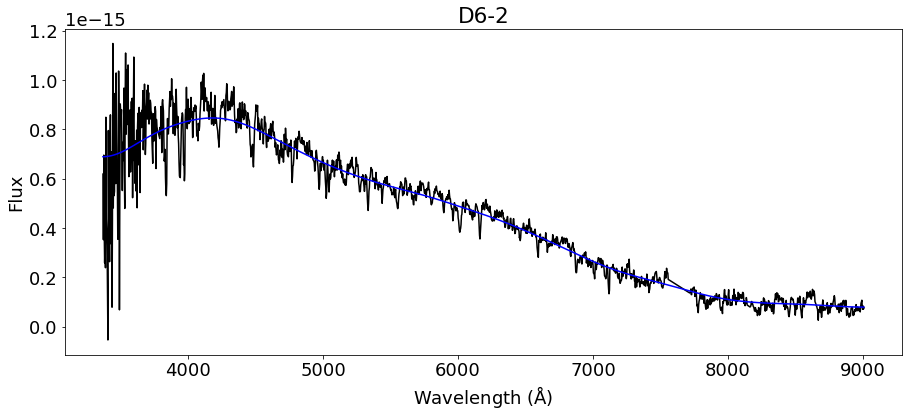

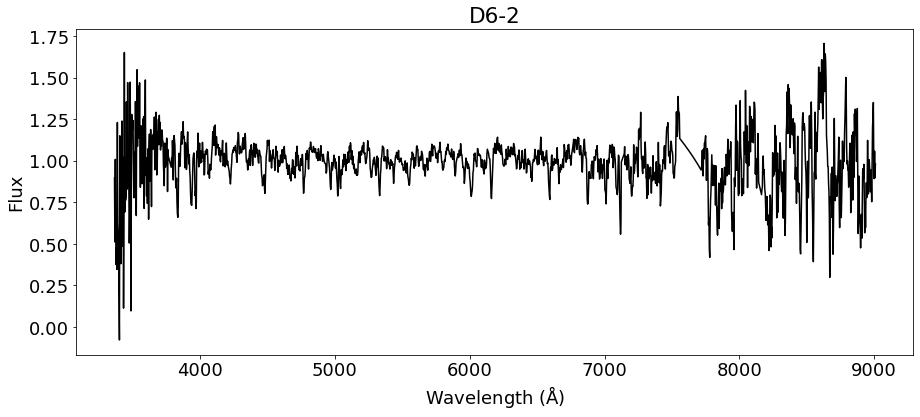

In [23]:
plt.figure(figsize = (15, 6))
continuum = scipy.ndimage.gaussian_filter1d(fl, sigma = 75)

plt.plot(wl, fl, 'k')
plt.plot(wl, continuum, 'b')
plt.title('D6-2')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

plt.figure(figsize = (15, 6))
plt.plot(wl, fl/continuum, 'k')
plt.title('D6-2')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

In [24]:
mwl = np.array(mwl)

Text(0, 0.5, 'Flux')

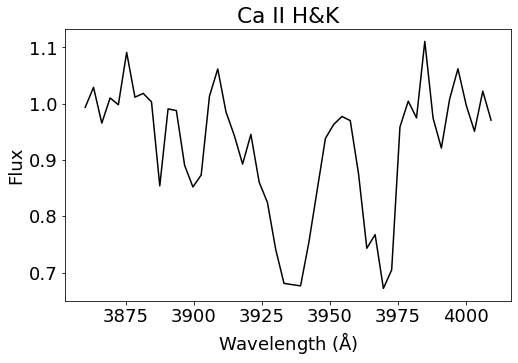

In [25]:
plt.figure(figsize = (8, 5))
cwl, cfl = cont_norm(wl, fl, ca2k, 75, 5)
plt.plot(cwl, cfl, 'k')

plt.title('Ca II H&K')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

In [36]:
import lmfit
from lmfit.models import VoigtModel, ConstantModel, GaussianModel

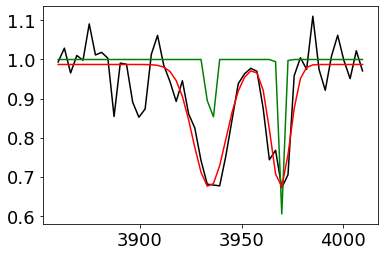

In [39]:
model = ConstantModel() - GaussianModel(prefix = 'k_') - GaussianModel(prefix = 'h_')
params = model.make_params()

params.add('RV', value = 0, min = -2500, max = 2500)

params['c'].set(value = 1)
params['k_center'].set(expr = str(ca2k) + '/ sqrt((1 - RV/2.99792458e5)/(1 + RV/2.99792458e5))')
params['k_amplitude'].set(value = 1)

params['h_center'].set(expr = str(ca2h) + '/ sqrt((1 - RV/2.99792458e5)/(1 + RV/2.99792458e5))')
params['h_amplitude'].set(value = 1)

res = model.fit(cfl, params, x = cwl)

plt.plot(cwl, cfl, 'k')
plt.plot(cwl, model.eval(params, x = cwl), 'g')
plt.plot(cwl, model.eval(res.params, x = cwl), 'r')

In [42]:
res.params

name,value,standard error,relative error,initial value,min,max,vary,expression
c,0.98724901,0.01092512,(1.11%),1,-inf,inf,True,
k_amplitude,6.37464688,0.80889175,(12.69%),1,-inf,inf,True,
k_center,3934.20776,0.58790668,(0.01%),3934.777,-inf,inf,False,3934.777/ sqrt((1 - RV/2.99792458e5)/(1 + RV/2.99792458e5))
k_sigma,8.08982344,1.04544463,(12.92%),1.0,0.00000000,inf,True,
h_amplitude,3.75158454,0.57306337,(15.28%),1,-inf,inf,True,
h_center,3969.01372,0.59309182,(0.01%),3969.588,-inf,inf,False,3969.588/ sqrt((1 - RV/2.99792458e5)/(1 + RV/2.99792458e5))
h_sigma,4.72411254,0.76917754,(16.28%),1.0,0.00000000,inf,True,
k_fwhm,19.0500780,2.46183393,(12.92%),2.35482,-inf,inf,False,2.3548200*k_sigma
k_height,0.31435992,0.03374496,(10.73%),0.3989423,-inf,inf,False,"0.3989423*k_amplitude/max(2.220446049250313e-16, k_sigma)"
h_fwhm,11.1244347,1.81127467,(16.28%),2.35482,-inf,inf,False,2.3548200*h_sigma


Text(0, 0.5, 'Flux')

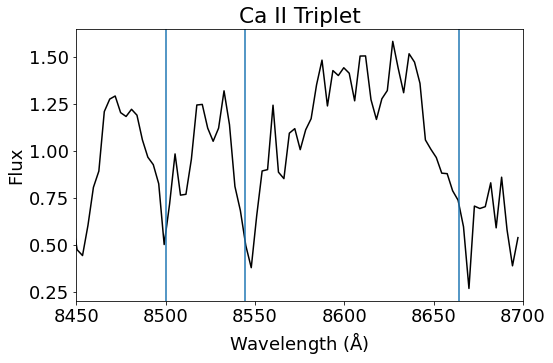

In [8]:
plt.figure(figsize = (8, 5))

cwl, cfl = cont_norm(wl, fl, 8550, 150, 50)

plt.plot(cwl, cfl, 'k')
plt.xlim(8450, 8700)
plt.title('Ca II Triplet')
plt.axvline(ca1)
plt.axvline(ca2)
plt.axvline(ca3)

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

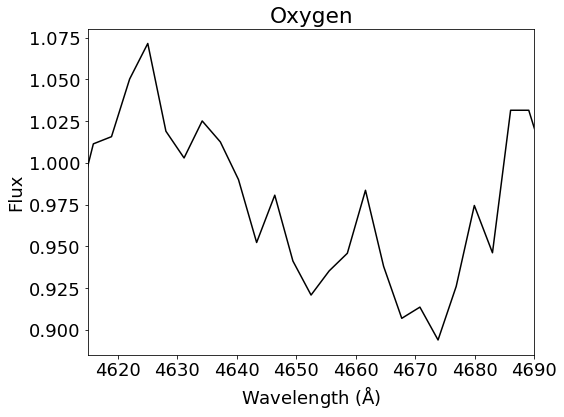

In [9]:
plt.figure(figsize = (8, 6))

cwl, cfl = cont_norm(wl, fl, 4650, 50, 5)
plt.plot(cwl, cfl, 'k')
plt.xlim(4615, 4690)
plt.title('Oxygen')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

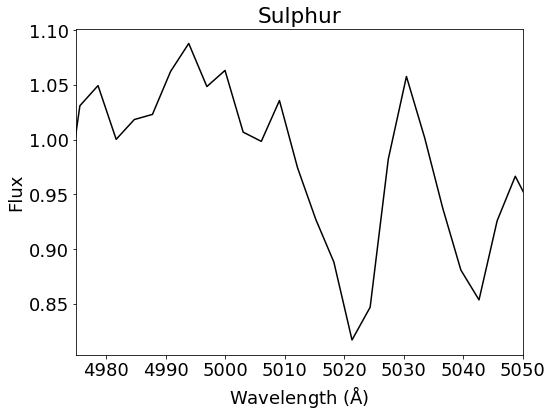

In [10]:
plt.figure(figsize = (8, 6))

cwl, cfl = cont_norm(wl, fl, 5020, 50, 5)

plt.plot(cwl, cfl, 'k')
plt.xlim(4975, 5050)
plt.title('Sulphur')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux')